# **Inversión de datos MT teóricos**

In [1]:
# Importar librerías

import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
import inspect
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

#MTpy
from mtpy import MT, MTCollection, MTData

#SimPEG
from simpeg.electromagnetics import natural_source as nsem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model
from discretize import TensorMesh
from simpeg import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)

matplotlib.rcParams.update({"font.size": 16})
from ipywidgets import interact, widgets
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tkinter import Tk, Button, filedialog

In [2]:
def run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N")

    #mesh_plot = mesh.plot_grid() ###

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    ### CORRECCIÓN ---
    survey = nsem.survey.Survey(source_list) ### Antes -> survey = nsem.survery.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs = dpred + noise
    return dobs, dpred

In [3]:
layer_tops = np.r_[0., -500., -1500., -2150., -3650., -5650.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[150., 30, 3., 50., 8., 50.][::-1]
frequencies = np.logspace(-3, 3, 20)
relative_error_rho = 0.01
floor_phase = 0.01
dobs, dpred = run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

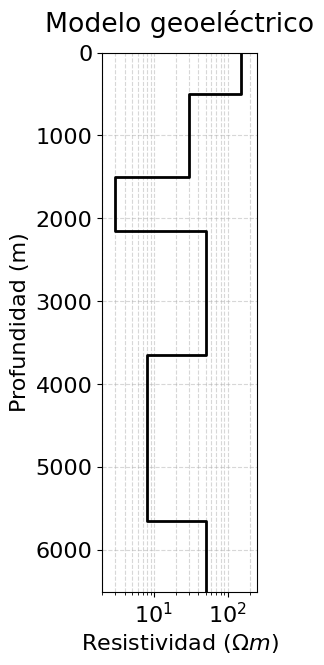

In [4]:
# Graficar el modelo
fig, ax = plt.subplots(figsize=(2, 7))
ax = plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax, color="black", label="Modelo teórico", lw= 2)
ax.set_xlabel(r"Resistividad ($\Omega m$)")
ax.set_ylabel(r"Profundidad (m)")
#ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax.set_ylim(6500, 0)
ax.set_xlim([10**0.3, 10**2.4])
ax.set_title("Modelo geoeléctrico", pad=15)
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil

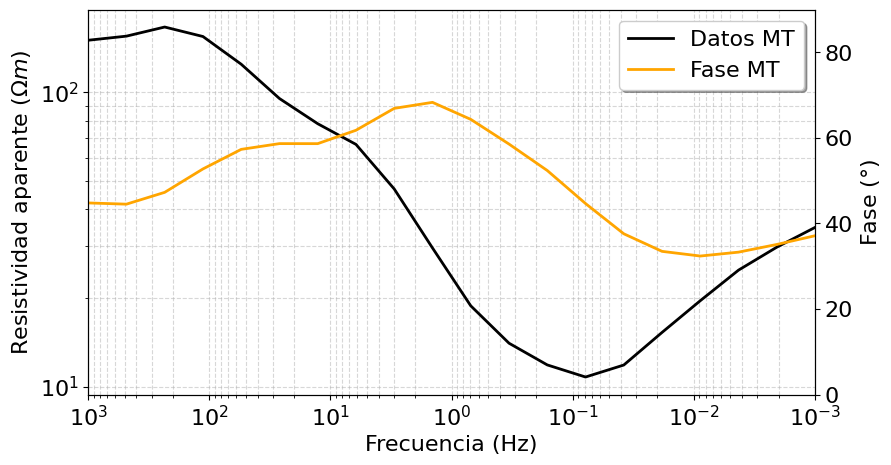

In [5]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0],  color='black', label='Datos MT', lw =2)
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='orange', label='Fase MT',  lw =2)
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax.set_xlabel("Frecuencia (Hz)")  
ax.set_xlim(frequencies.max(), frequencies.min())

ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='orange', lw = 2)  
ax_1.set_ylim(0, 90)    
ax_1.set_ylabel("Fase ($\degree$)")
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
plt.show()

In [6]:
def run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=0.1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1
    ):
    
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(
        mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref,
        mapping=maps.IdentityMap(mesh=mesh_inv)
    )

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)

    # The directives are defined as a list.
    directives_list = [
        starting_beta,
        beta_schedule,
        target_misfit,
        save_dictionary
    ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict

In [7]:
dz = 20
n_layer = 24
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]
print("El espesor total del modelo será:", layer_thicknesses_inv.sum(), "metros")

El espesor total del modelo será: 6524.737266949234 metros


In [8]:
rho_app = dobs.reshape((len(frequencies), 2))[:,0]
phase = dobs.reshape((len(frequencies), 2))[:,1]
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()

rho_0 = 100 #100
rho_ref = 100 #100

output_dict ={}
recovered_model, output_dict = run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=25,
    alpha_s=1e-10,      
    alpha_z=1,
    beta0_ratio=1e2,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1e-2,
)

target_misfit = dobs.size / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.25e+09  3.46e+07  0.00e+00  3.46e+07    9.51e+06      0              
   1  1.62e+09  9.42e+06  1.96e-03  1.26e+07    6.28e+06      0              
   2  8.12e+08  3.23e+06  3.98e-03  6.47e+06    2.23e+06      0   Skip BFGS  
   3  4.06e+08  1.48e+06  5.37e-03  3.66e+06    1.15e+06      0   Skip BFGS  
   4  2.03e+08  8.46e+05  6.42e-03  2.15e+06    6.49e+05      0   Skip BFGS  
   5  1.02e+08  5.60e+05  7.37e-03  1.31e+06    3.84e+05      0   Skip

In [9]:
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [10]:
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=25, description='iteration', max=25, min=1), RadioButtons(description='s…

In [11]:
s5 = np.array([3.90243394e+02, 4.98445944e+02, 7.75098810e+02, 1.37008401e+03,
 2.22647122e+03, 2.37796964e+03, 1.22542056e+03, 3.70380491e+02,
 2.60625960e+02, 1.91429727e+03, 2.36574669e+04, 1.59446592e+04,
 4.40295040e+02, 1.73623517e+02, 3.34598497e+02, 1.17809028e+02,
 8.41367504e+01, 5.50251058e+03, 4.32733541e+03, 1.33203537e+01,
 7.09059034e+01, 5.81735302e+01, 1.10035170e+01, 2.16279926e+02])

s05 = np.array([31.44456462, 28.1287529,  28.70875436, 33.2081297,  34.58609854, 24.74187144,
 10.83817317,  5.18670367,  6.08299753,  7.74748903,  4.66065006,  0.77191349,
  0.73592239,  2.3297576,   4.31761676,  4.50371814,  2.82998452,  1.71746725,
  2.89041527,  9.29308344, 19.77886985, 18.22044983,  9.19521374,  9.77351994])

[161.87608089 155.70109996 147.16761297 140.56640065 141.25035958
 152.6671154  171.31717957 178.83465418 147.38150545  81.23664486
  33.21208785  28.15895182  27.68193326  35.50835551  47.42336894
   4.05001887   2.57459367  39.02782258  67.27468417  34.27762356
   7.87152929   7.46060186  27.17715888  50.55624909]


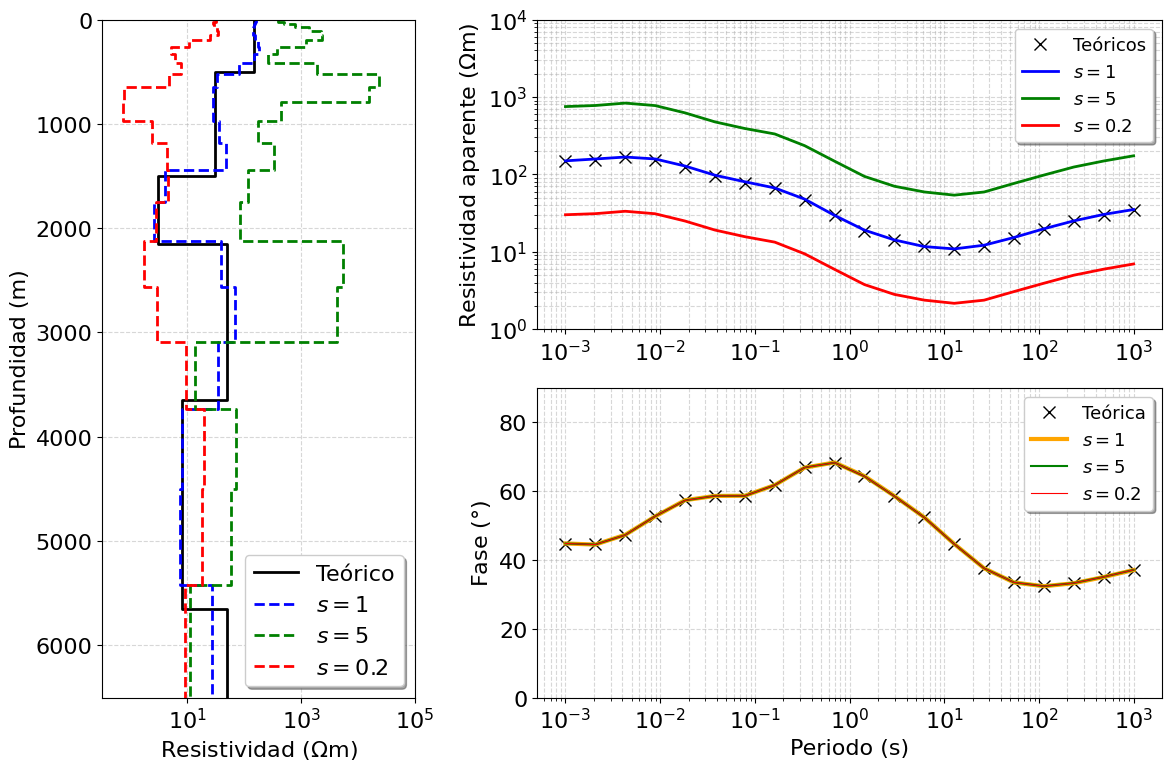

In [12]:
def plot_model_and_measurements(iteration):
    dpred = output_dict[iteration]['dpred']  # Datos predichos
    m = output_dict[iteration]['m']  # Modelo invertido
    print((1./(np.exp(m)))[::-1])
    # Crear la figura y los subgráficos
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1])  # 2 filas, 2 columnas

    # Subgráfico 1: Modelo de resistividades (izquierda)
    ax0 = fig.add_subplot(gs[:, 0])  # Ocupa todas las filas de la primera columna
    plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", label='Teórico', lw=2)
    plot_1d_layer_model(layer_thicknesses_inv[::-1], (1./(np.exp(m)))[::-1], ax=ax0, color="blue", linestyle='--', label='$\mathit{s}=1$', lw=2)
    plot_1d_layer_model(layer_thicknesses_inv[::-1], s5, ax=ax0, color="green", linestyle='--', label='$\mathit{s}=5$', lw=2)
    plot_1d_layer_model(layer_thicknesses_inv[::-1], s05, ax=ax0, color="red", linestyle='--', label='$\mathit{s}=0.2$', lw=2)
    ax0.grid(True, which="both", linestyle='--', alpha=0.5)
    ax0.set_xlabel("Resistividad ($\Omega$m)")
    ax0.set_xlim([10**-0.5, 10**5])
    ax0.set_ylim(6500, 0)
    ax0.set_ylabel("Profundidad (m)")
    ax0.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

    # Subgráfico 2: Mediciones de resistividad aparente (derecha, arriba)
    ax1 = fig.add_subplot(gs[0, 1])  # Primera fila, segunda columna
    ax1.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 0], 'x', color='k', label='Teóricos', lw=2, markersize=8)
    ax1.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:, 0], color='blue', label='$\mathit{s}=1$', lw=2)
    ax1.loglog(1./frequencies, (5*dobs.reshape((len(frequencies), 2))[:, 0]), color='green', label='$\mathit{s}=5$', lw=2)
    ax1.loglog(1./frequencies, (1/5*dobs.reshape((len(frequencies), 2))[:, 0]), color='red', label='$\mathit{s}=0.2$', lw=2)
    ax1.grid(True, which="both", linestyle='--', alpha=0.5)
    ax1.set_ylabel("Resistividad aparente ($\Omega$m)")
    ax1.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=13)
    ax1.set_ylim([10**0, 10**4])

    # Subgráfico 3: Mediciones de fase (derecha, abajo)
    ax2 = fig.add_subplot(gs[1, 1])  # Segunda fila, segunda columna
    ax2.semilogx(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 1], 'x', color='k', label='Teórica', markersize=8)
    ax2.semilogx(1./frequencies, dpred.reshape((len(frequencies), 2))[:, 1], color='orange', label='$\mathit{s}=1$', lw=3)
    ax2.semilogx(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 1], color='green', label='$\mathit{s}=5$', lw=1.5)
    ax2.semilogx(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 1], color='red', label='$\mathit{s}=0.2$', lw=0.8)
    ax2.grid(True, which="both", linestyle='--', alpha=0.5)
    ax2.set_xlabel("Periodo (s)")
    ax2.set_ylabel("Fase ($\degree$)")
    ax2.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=13)
    ax2.set_ylim([0, 90])

    # Ajustar el espaciado entre subgráficos
    plt.tight_layout()

    # Guardar la figura
    filename = "Modelo_y_Mediciones4.svg"
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')

    plt.show()
    

# Llamar a la función con la última iteración
plot_model_and_measurements(n_iteration)

In [13]:
## Datos observados y predichos
dobs = dobs.reshape((len(frequencies), 2))[:, 0]  # Asegúrate de que dobs y dpred tengan la misma forma
dpred = dpred.reshape((len(frequencies), 2))[:, 0]

# Calcular el MSE
mse = np.mean((dobs - dpred) ** 2)

# Calcular el RMS
rms = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMS: {rms}")

MSE: 0.6463998755995826
RMS: 0.8039899723252664
